In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import libimagetransfer.align

In [2]:
# EXAMPLE_DIR = "./examples/twotowers_vista_1_00"
EXAMPLE_DIR = "./examples/twotowers_rope"
# EXAMPLE_DIR = "./examples/twotowers_gollum_9_19"

# Read images in color and grayscale, cropping any letterboxing.
def crop_letterbox(path):
    img_color = cv2.imread(path)
    y_nonzero, x_nonzero = np.nonzero(img_color)[:2]
    crop_y = slice(np.min(y_nonzero),np.max(y_nonzero))
    crop_x = slice(np.min(x_nonzero),np.max(x_nonzero))

    # Read the image a second time to get the grayscale because that can use a codec-specific grayscale calculation that may lose less information
    img_gray = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    
    return img_color[crop_y, crop_x], img_gray[crop_y, crop_x]

frame_480, frame_480_gray = crop_letterbox(f"{EXAMPLE_DIR}/480p.jpg")
frame_2160, frame_2160_gray = crop_letterbox(f"{EXAMPLE_DIR}/2160p.jpg")

In [3]:
# Helper functions
def show_bgr(img):
    if len(img.shape) > 2 and img.shape[2] > 1:
        plt.imshow(img[:,:,::-1])
    else:
        plt.imshow(img)
    plt.show()

In [4]:
# Find affine matrix to align images
M_2160_to_480 = libimagetransfer.align.find_alignment_transform(frame_480_gray, frame_2160_gray)
display(M_2160_to_480)

array([[ 2.20516399e-01,  2.69537248e-04,  3.59942492e-01],
       [-2.69537248e-04,  2.20516399e-01,  2.68667546e+00]])

In [5]:
# Perform the alignment and crop both images to ensure they use the same area.
# In case the 2160p version of the image is only a subset of the 480p version, crop the 480p version down
min_point_2160 = M_2160_to_480.dot(np.array([0, 0, 1]))
max_point_2160 = M_2160_to_480.dot(np.array([frame_2160.shape[0], frame_2160.shape[1], 1]))
display(min_point_2160, max_point_2160, frame_480.shape)

crop_y = slice(max(int(min_point_2160[0]), 0), min(int(max_point_2160[0]), frame_480.shape[0]))
crop_x = slice(max(int(min_point_2160[1]), 0), min(int(max_point_2160[1]), frame_480.shape[1]))
frame_480_crop = frame_480[crop_y, crop_x]

# Warp the 2160p image to the full 480p shape, then crop it down
rows, cols = frame_480.shape[:2]
frame_2160_aligned_480 = cv2.warpAffine(frame_2160, M_2160_to_480, (cols, rows))
frame_2160_aligned_480_crop = frame_2160_aligned_480[crop_y, crop_x]

array([0.35994249, 2.68667546])

array([357.52868059, 848.8138291 ])

(359, 847, 3)

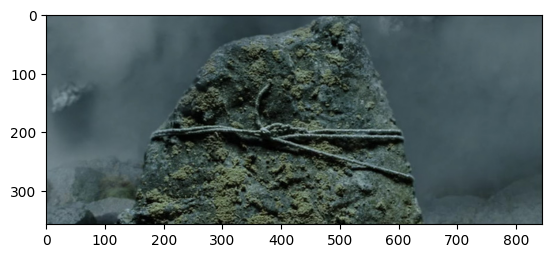

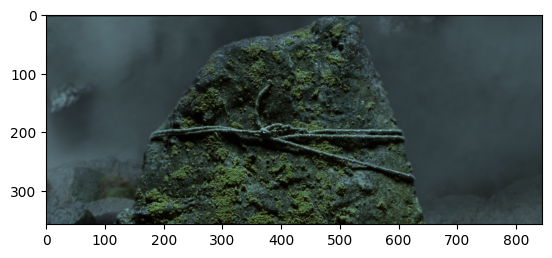

In [6]:
show_bgr(frame_480_crop)
show_bgr(frame_2160_aligned_480_crop)

array([[[43.121338, -4.671875, -6.03125 ],
        [41.967773, -6.515625, -5.375   ],
        [42.37671 , -6.53125 , -5.375   ],
        ...,
        [37.530518, -3.96875 , -5.90625 ],
        [39.178467, -3.984375, -5.890625],
        [34.60083 , -3.984375, -5.96875 ]],

       [[47.55249 , -4.59375 , -5.9375  ],
        [46.40503 , -6.453125, -5.296875],
        [46.801758, -6.46875 , -5.296875],
        ...,
        [42.456055, -3.96875 , -5.8125  ],
        [44.085693, -3.9375  , -5.765625],
        [39.587402, -4.      , -5.875   ]],

       [[43.530273, -4.65625 , -6.015625],
        [42.77954 , -6.515625, -5.359375],
        [42.77954 , -6.515625, -5.359375],
        ...,
        [38.76953 , -3.984375, -5.890625],
        [40.83252 , -3.953125, -5.84375 ],
        [36.273193, -4.015625, -5.9375  ]],

       ...,

       [[49.005127, -3.4375  , -4.890625],
        [49.627686, -4.25    , -4.859375],
        [49.212646, -4.375   , -4.59375 ],
        ...,
        [45.007324, -5.312

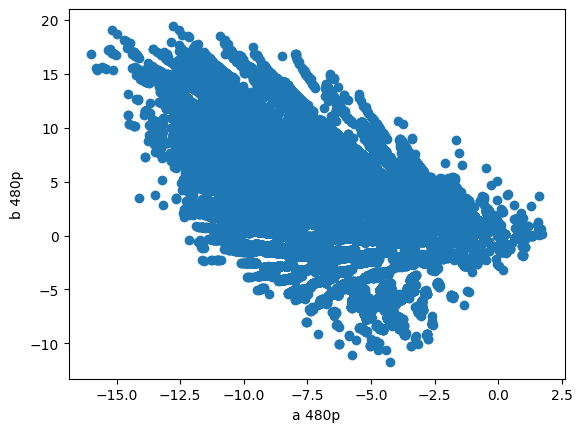

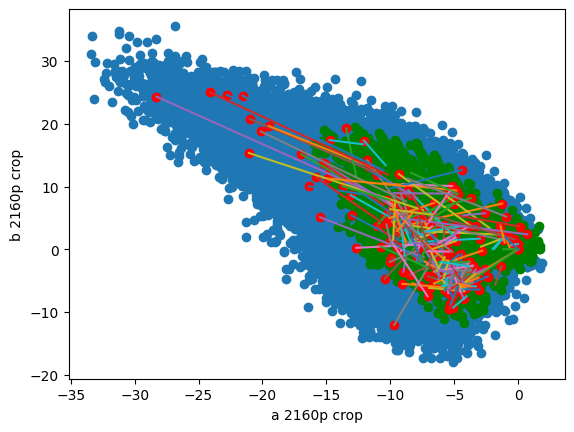

[-4.671875 -6.515625 -6.53125  ... -6.171875 -6.125    -5.734375]
[-4.671875 -6.515625 -6.53125  ... -6.171875 -6.125    -5.734375]


C:\Users\Samuel\.virtualenvs\FrameRecolor-fQiOPjPb\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


array([ 0.        ,  0.28059173, -0.04597195, -4.46399593])

array([ 0.        ,  0.09962336,  0.77510891, -1.25936717])

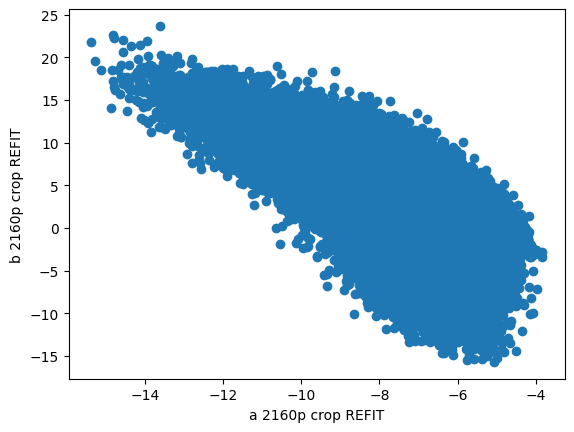

In [7]:
# Now, to transfer color from frame_480_crop to frame_2160_aligned_480_crop.
# My vague idea is to look at each pixel where the luminance on both sides is non-negligible (NOTE this requires asserting that the luminance is approx. the same for both frames), 
# deciding on some nonlinear function F_color(Cr_2160, Cb_2160) -> Cr_480, Cb_480 with weights W, and fitting W based on those pixels.
# Then you can apply F_color to each pixel of the original 2160p image to get a 4K image with the color """"profile"""" of the 480p frame.
# The colorspace for this function is critical - it may be better to work in RGB, HSL, or some other color space.
# In fact, if you're going to ignore luminance in F_color, maybe you should take and produce Hue/Saturation? I foresee some issues with interpolation here, though.
# Ok, no, F has to at least take in three arguments, or it at least can't do CrCb because that just ignores green lolllll

frame_480_YCrCb = cv2.cvtColor(frame_480_crop, cv2.COLOR_BGR2YCR_CB)
frame_2160_YCrCb = cv2.cvtColor(frame_2160_aligned_480_crop, cv2.COLOR_BGR2YCR_CB)
# display(frame_480_YCrCb)

frame_480_crop_Lab = cv2.cvtColor(frame_480_crop.astype(np.float32) * (1./255), cv2.COLOR_BGR2Lab)
frame_2160_crop_Lab = cv2.cvtColor(frame_2160_aligned_480_crop.astype(np.float32) * (1./255), cv2.COLOR_BGR2Lab)
frame_2160_Lab = cv2.cvtColor(frame_2160.astype(np.float32) * (1./255), cv2.COLOR_BGR2Lab)
display(frame_480_crop_Lab)

# Convert a and b to 0..1 range values (per OpenCV -127 <= a,b <= 127) bc I *think* that makes it easier/possible to do nice fitting
def extract_comp(dat, idx):
    # return (dat[:, :, idx].reshape([-1]) + 127) / 254
    return dat[:, :, idx].reshape([-1])

a_480 = extract_comp(frame_480_crop_Lab, 1)
b_480 = extract_comp(frame_480_crop_Lab, 2)
plt.scatter(a_480, b_480)
plt.xlabel('a 480p')
plt.ylabel('b 480p')
plt.show()


a_2160_crop = extract_comp(frame_2160_crop_Lab, 1)
b_2160_crop = extract_comp(frame_2160_crop_Lab, 2)
plt.scatter(a_2160_crop, b_2160_crop)
plt.plot(
    np.vstack([a_480[::1000], a_2160_crop[::1000]]),
    np.vstack([b_480[::1000], b_2160_crop[::1000]]),
    "-"
)
plt.scatter(a_480, b_480, c='green')
plt.scatter(a_2160_crop[::1000], b_2160_crop[::1000], c='red')
plt.xlabel('a 2160p crop')
plt.ylabel('b 2160p crop')
plt.show()

# a_2160 = extract_comp(frame_2160_Lab, 1)
# b_2160 = extract_comp(frame_2160_Lab, 2)
# plt.scatter(a_2160, b_2160)
# plt.xlabel('a 2160p')
# plt.ylabel('b 2160p')
# plt.show()

# Experiment - train weights for two functions: one produces a', one produces b'
# (a2 + a + 1)(b2 + b + 1) = a2b2 + a2b + a2 + b2a + ab + a + b2 + b + 1
# maybe tone it down to ab + a + b + 1 = (a + 1)(b + 1)
def f_lin(a_and_b, w1, w2, w3, w4):
    a, b = a_and_b
    return (a * w2) + (b * w3) + w4
# Initial guesses: a' = a, b' = b
INITIAL_FOR_A_LIN = (0, 1, 0, 0)
INITIAL_FOR_B_LIN = (0, 0, 1, 0)

print(f_lin((a_480, b_480), *INITIAL_FOR_A_LIN))
print(a_480)

from scipy.optimize import curve_fit
a_lin_curve, _ = curve_fit(f_lin, (a_2160_crop, b_2160_crop), a_480, p0=INITIAL_FOR_A_LIN)
b_lin_curve, _ = curve_fit(f_lin, (a_2160_crop, b_2160_crop), b_480, p0=INITIAL_FOR_B_LIN)
display(a_lin_curve, b_lin_curve)

a_2160_mod = f_lin((a_2160_crop, b_2160_crop), *a_lin_curve)
b_2160_mod = f_lin((a_2160_crop, b_2160_crop), *b_lin_curve)
plt.scatter(a_2160_mod, b_2160_mod)
plt.xlabel('a 2160p crop REFIT')
plt.ylabel('b 2160p crop REFIT')
plt.show()

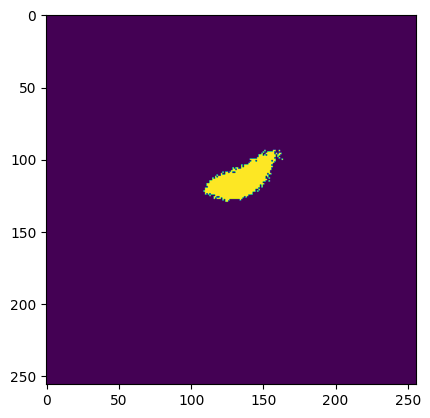

In [8]:
# uhhh fuck
# LUT???
DARK_THRESHOLD=5

dst_Lab = frame_480_crop_Lab.reshape([-1, 3])
src_Lab = frame_2160_crop_Lab.reshape([-1, 3])
selector = (src_Lab[:, 0] > DARK_THRESHOLD) & (dst_Lab[:, 0] > DARK_THRESHOLD)
src_Lab = src_Lab[selector]
dst_Lab = dst_Lab[selector]

LUT_DIM = (256, 256, 4) # elements of 3D lut = Ldelta, adelta, bdelta, count
LUT_DIV = (256/LUT_DIM[0], 256/LUT_DIM[1])
LUT = np.zeros(LUT_DIM)

lut_elements = np.column_stack([src_Lab[:, 0], np.rint((src_Lab[:, 1] + 127) / LUT_DIV[0]), np.rint((src_Lab[:, 2] + 127) / LUT_DIV[1]), dst_Lab - src_Lab])
for L, lut_a, lut_b, L_delta, a_delta, b_delta in lut_elements:
    LUT[int(lut_a), int(lut_b)] += [L_delta, a_delta, b_delta, 1]
# Finalize the LUT process by dividing the sum of deltas by count - computing the average delta
# LUT[LUT[:,:,3] > 0] = LUT[LUT[:,:,3] > 0] / LUT[LUT[:,:,3] > 0][3]
for x in range(LUT_DIM[0]):
    for y in range(LUT_DIM[1]):
        if LUT[x, y, 3] == 0:
            continue
        LUT[x, y] /= LUT[x, y, 3]
        
plt.imshow(LUT[:,:,3] > 0)
        # plt.plot([x, x + LUT[x, y, 1] / LUT_DIV[0]], [y, y + LUT[x, y, 2] / LUT_DIV[1]], '-')
plt.show()

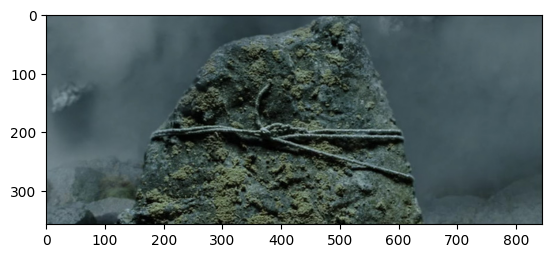

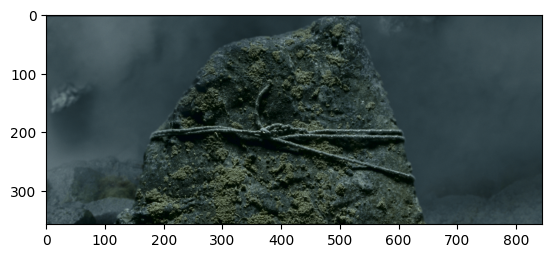

In [9]:
frame_2160_crop_Lab_mod = frame_2160_crop_Lab.copy()
frame_2160_crop_Lab_mod[:,:,1:3] += LUT[np.rint((frame_2160_crop_Lab_mod[:, :, 1] + 127) / LUT_DIV[0]).astype(np.int32), np.rint((frame_2160_crop_Lab_mod[:, :, 2] + 127) / LUT_DIV[1]).astype(np.int32), 1:3]
frame_2160_crop_Lab_mod_bgr = cv2.cvtColor(frame_2160_crop_Lab_mod, cv2.COLOR_Lab2BGR)

show_bgr(frame_480_crop)
show_bgr(frame_2160_crop_Lab_mod_bgr)

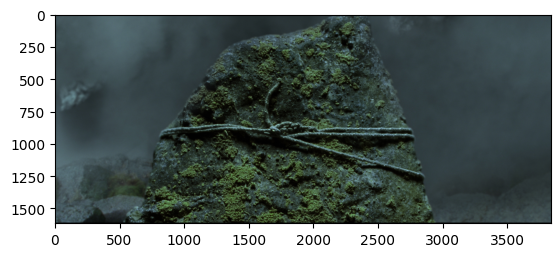

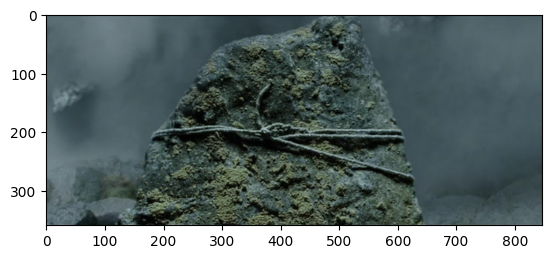

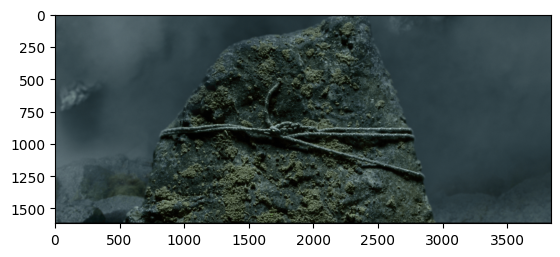

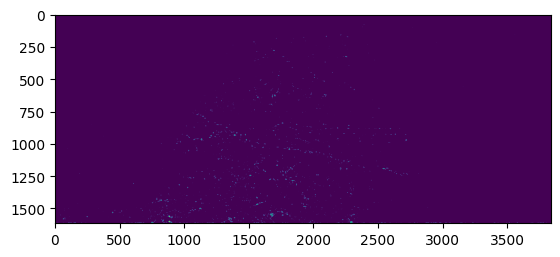

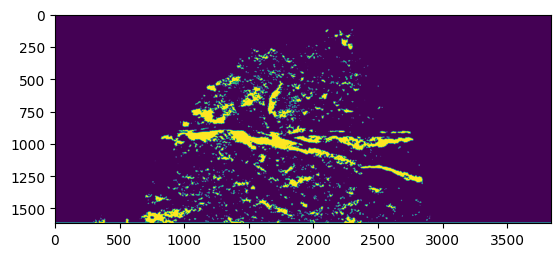

[[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  ...
  [3.91492977e-05 3.88447521e-03 6.77263015e-05]
  [0.00000000e+00 7.80938612e-03 4.60717238e-05]
  [0.00000000e+00 7.80938612e-03 4.60717238e-05]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00]]

 [[1.17280008e-02 3.93785164e-03 2.69860848e-05]
  [7.82599207e-03 3.28401875e-05 1.08508364e-04]
  [7.82599207e-03 3.28401875e-05 1.08508364e-04]
  ...
  [1.17993690e-02 2.35259540e-05 7.82459229e-03]
  [1.17993690e-02 2.35259540e-05 7.82459229e-03]
  [1.17993690e-02 2.35259540e-05 7.82459229e-03]]

 ...

 [[2.35232897e-02 1.56780984e-02 2.97644638e-05]
  [2.35232897e-02 1.56780984e-02 2.9764

True

In [10]:
# oh fuck that looks promising
frame_2160_Lab_corrected = frame_2160_Lab[:,:,1:3] + LUT[np.rint((frame_2160_Lab[:, :, 1] + 127) / LUT_DIV[0]).astype(np.int32), np.rint((frame_2160_Lab[:, :, 2] + 127) / LUT_DIV[1]).astype(np.int32), 1:3]
frame_2160_Lab_mod = frame_2160_Lab.copy()
frame_2160_Lab_mod[frame_2160_Lab_mod[:,:,0] > DARK_THRESHOLD, 1:3] = frame_2160_Lab_corrected[frame_2160_Lab_mod[:,:,0] > DARK_THRESHOLD]
frame_2160_Lab_mod_bgr = cv2.cvtColor(frame_2160_Lab_mod, cv2.COLOR_Lab2BGR)

show_bgr(frame_2160)
show_bgr(frame_480)
show_bgr(frame_2160_Lab_mod_bgr)
# Show where the original frame didn't have any elements in the LUT
plt.imshow(LUT[np.rint((frame_2160_Lab[:, :, 1] + 127) / LUT_DIV[0]).astype(np.int32), np.rint((frame_2160_Lab[:, :, 2] + 127) / LUT_DIV[1]).astype(np.int32), 3] == 0)
plt.show()
# Show where the original frame is dark
plt.imshow(frame_2160_Lab[:, :, 0] <= DARK_THRESHOLD)
plt.show()
print(frame_2160_Lab_mod_bgr)
cv2.imwrite("twotowers_test.jpg", frame_2160_Lab_mod_bgr*255)